# <center> Recommender System </center>

## Preparation

Connect to drive (if needed)

In [46]:
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.preprocessing import normalize

DRIVE_DIR = ""
USING_DRIVE = False
if USING_DRIVE:
    # from google.colab import drive
    # drive.mount('/content/drive')
    DRIVE_DIR = "drive/My Drive/Bangkit/"

# Check GPU
devices = tf.config.experimental.list_physical_devices()
for device in devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


Constants

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

LOG_NAME = "recommender-frelevantprice"
REMARK = "Try current best model with more relevant pricing"
BATCH_SIZE = 1024
LEARNING_RATE = 1e-5
EPOCH = 100
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS_FN = tf.keras.losses.MeanSquaredError()

Log dir

In [48]:
DETAIL_DIR = os.path.join(DRIVE_DIR, "log/detail/")
MODEL_DIR = os.path.join(DRIVE_DIR, "log/model/savedmodel/")
KERAS_DIR = os.path.join(DRIVE_DIR, "log/model/keras/")
PLOT_DIR = os.path.join(DRIVE_DIR, "log/plot")
SUMMARY_DIR = os.path.join(DRIVE_DIR, "log/model/summary/")

if (os.path.exists(os.path.join(MODEL_DIR, LOG_NAME)) or 
    os.path.exists(os.path.join(KERAS_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(PLOT_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(SUMMARY_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME))):
    raise FileExistsError


## Data Extraction

### Load data from CSV

Not using user data for a while

Data is generated randomly using Excel

In [49]:
DATA_DIR = os.path.join(DRIVE_DIR, "data/synt_data_better_price_and_follower/")
INFLUENCER_FILE = os.path.join(DATA_DIR, "data_content_influencer_categ.csv")
OWNER_FILE = os.path.join(DATA_DIR, "data_content_owner_categ.csv")
HISTORY_FILE = os.path.join(DATA_DIR, "historical_data.csv")

df_influencer = pd.read_csv(INFLUENCER_FILE)
# df_owner = pd.read_csv(OWNER_FILE)
df_history = pd.read_csv(HISTORY_FILE)

### Data Exploration

In [50]:
df_influencer.head(5)

,id,insta_follower,tiktok,youtube,categories,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH
0,1723,6018900,8078640,15046770,"Category 8,Category 2",9.37,0,0,1,1,1
1,82,23809950,35177250,44279670,"Category 4,Category 2,Category 1,Category 8,Ca...",9.26,0,0,1,1,1
2,296,3427860,5198670,5264340,"Category 6,Category 1,Category 4,Category 5",9.25,0,0,1,1,0
3,127,20207160,38229630,74752350,"Category 7,Category 6",9.17,0,0,1,1,1
4,137,4537980,8215080,13298910,"Category 6,Category 1,Category 4,Category 5",9.16,0,0,1,1,1


In [51]:
df_influencer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6406 entries, 0 to 6405
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 6406 non-null   int64  
 1   insta_follower     6406 non-null   int64  
 2   tiktok             6406 non-null   int64  
 3   youtube            6406 non-null   int64  
 4   categories         6406 non-null   object 
 5   avg_rating         6406 non-null   float64
 6   pricing_LOW        6406 non-null   int64  
 7   pricing_BELOW_AVG  6406 non-null   int64  
 8   pricing_AVG        6406 non-null   int64  
 9   pricing_ABOVE_AVG  6406 non-null   int64  
 10  pricing_HIGH       6406 non-null   int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 550.6+ KB


In [52]:
df_influencer.describe()

,id,insta_follower,tiktok,youtube,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH
count,6406.000000,6.406000e+03,6.406000e+03,6.406000e+03,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000
mean,3505.326881,9.936103e+05,1.405106e+06,1.952503e+06,6.954530,0.625976,0.716984,0.230097,0.089291,0.063534
std,2153.761090,2.158019e+06,3.200647e+06,4.601825e+06,0.804705,0.483908,0.450499,0.420927,0.285186,0.243940
min,1.000000,1.290000e+03,1.260000e+03,2.490000e+03,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1607.250000,6.016500e+04,8.160750e+04,1.084950e+05,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3312.500000,2.187150e+05,2.956500e+05,4.113000e+05,7.010000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,5384.750000,8.947575e+05,1.201725e+06,1.692038e+06,7.470000,1.000000,1.000000,0.000000,0.000000,0.000000
max,7387.000000,3.041751e+07,4.039176e+07,7.475235e+07,9.370000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
df_history.head(5)

,own_id,inf_id,star_rating,sentiment_rating
0,1,1,4,0.77
1,1,3,3,0.53
2,1,5,5,0.89
3,1,6,5,0.90
4,1,7,4,0.80


In [54]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413446 entries, 0 to 413445
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   own_id            413446 non-null  int64  
 1   inf_id            413446 non-null  int64  
 2   star_rating       413446 non-null  int64  
 3   sentiment_rating  413446 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 12.6 MB


In [55]:
df_history.describe()

,own_id,inf_id,star_rating,sentiment_rating
count,413446.000000,413446.000000,413446.000000,413446.000000
mean,2443.219533,1076.748458,4.141170,0.777486
std,1438.596784,1148.850785,0.789503,0.161847
min,1.000000,1.000000,1.000000,0.000000
25%,1214.000000,260.000000,4.000000,0.680000
50%,2456.000000,639.000000,4.000000,0.790000
75%,3699.000000,1532.000000,5.000000,0.900000
max,5000.000000,7385.000000,5.000000,1.000000


## Data Transformation

### Data cleaning

#### Missing value

In [56]:
df_influencer.isnull().sum()

id                   0
insta_follower       0
tiktok               0
youtube              0
categories           0
avg_rating           0
pricing_LOW          0
pricing_BELOW_AVG    0
pricing_AVG          0
pricing_ABOVE_AVG    0
pricing_HIGH         0
dtype: int64

In [57]:
df_history.isnull().sum()

own_id              0
inf_id              0
star_rating         0
sentiment_rating    0
dtype: int64

No missing value

#### Irrelevant Data / Invalid Data

Check if all history has valid influencer and owner ID

In [58]:
df_history["inf_id"].isin(df_influencer["id"]).all()

True

All history data has valid influencer and owner ID

### Data Normalization

Normalize influencer data: Scale follower count and One-hot categories

In [59]:
def one_hot(df, column):
    one_hot = df[column].str.get_dummies()
    col_name = one_hot.columns
    new_name = list(map(lambda name: column + "_" + name, col_name))
    one_hot.rename(columns={k: v for k, v in zip(col_name, new_name)}, inplace=True)

    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(column, axis=1)
    return df


In [60]:
YOUTUBE_HIGH_THRES = 2_000_000
YOUTUBE_LOW_THRES = 100_000
TIKTOK_HIGH_THRES = 2_000_000
TIKTOK_LOW_THRES = 100_000
INSTAGRAM_HIGH_THRES = 1_000_000
INSTAGRAM_LOW_THRES = 50_000

# follower_scaler = MinMaxScaler()

df_inf_norm = df_influencer.copy()
df_inf_norm['avg_rating'] = df_inf_norm[['avg_rating']] / 10
# df_inf_norm[["insta_follower", "tiktok", "youtube"]] = follower_scaler.fit_transform(df_inf_norm[["insta_follower", "tiktok", "youtube"]])

# df_inf_norm = one_hot(df_inf_norm, 'price_category') 

one_hot_categories = df_inf_norm['categories'].str.get_dummies(sep=',')
df_inf_norm = pd.concat([df_inf_norm, one_hot_categories], axis=1)
df_inf_norm = df_inf_norm.drop('categories', axis=1)

youtube_bin = [0, YOUTUBE_LOW_THRES, YOUTUBE_HIGH_THRES, df_inf_norm['youtube'].max()]
tiktok_bin = [0, TIKTOK_LOW_THRES, TIKTOK_HIGH_THRES, df_inf_norm['tiktok'].max()]
insta_bin = [0, INSTAGRAM_LOW_THRES, INSTAGRAM_HIGH_THRES, df_inf_norm['insta_follower'].max()]

df_inf_norm['youtube'] = pd.cut(df_inf_norm['youtube'],bins=youtube_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'youtube') 

df_inf_norm['tiktok'] = pd.cut(df_inf_norm['tiktok'],bins=tiktok_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'tiktok') 

df_inf_norm['insta_follower'] = pd.cut(df_inf_norm['insta_follower'],bins=insta_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'insta_follower') 

df_inf_norm.head()

,id,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,1723,0.937,0,0,1,1,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
1,82,0.926,0,0,1,1,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0
2,296,0.925,0,0,1,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,127,0.917,0,0,1,1,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,137,0.916,0,0,1,1,1,1,0,0,...,0,1,0,0,1,0,0,1,0,0


Combine star and sentiment rating

In [61]:
STAR_WEIGHT = 0.5
SENTIMENT_WEIGHT = 0.5

df_history["combined_rating"] = STAR_WEIGHT * df_history["star_rating"] / 5 + SENTIMENT_WEIGHT * df_history["sentiment_rating"]
df_history

,own_id,inf_id,star_rating,sentiment_rating,combined_rating
0,1,1,4,0.77,0.785
1,1,3,3,0.53,0.565
2,1,5,5,0.89,0.945
3,1,6,5,0.90,0.950
4,1,7,4,0.80,0.800
...,...,...,...,...,...
413441,4999,49,5,0.90,0.950
413442,4999,670,5,0.84,0.920
413443,4999,62,5,0.92,0.960
413444,4999,770,5,0.93,0.965


In [62]:
rating_count = df_history.groupby("star_rating").count()
rating_count

,own_id,inf_id,sentiment_rating,combined_rating
star_rating,,,,
1,2768,2768,2768,2768
2,9217,9217,9217,9217
3,59531,59531,59531,59531
4,197295,197295,197295,197295
5,144635,144635,144635,144635


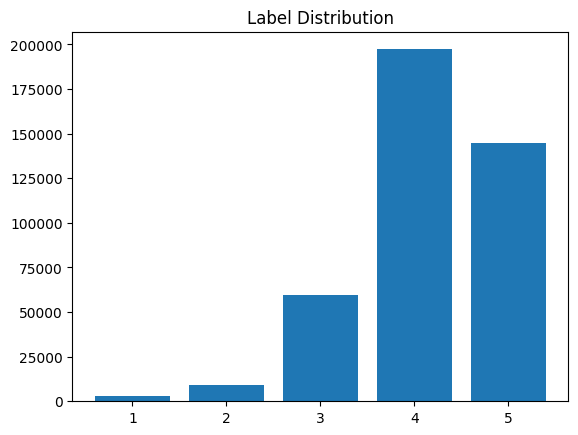

In [63]:
# Chart labels
rating_count = rating_count["own_id"].to_numpy()
ratings = range(1, 6)

# Show pie chart
plt.title("Label Distribution")
plt.bar(x=ratings, height=rating_count)
plt.show()

### Data Splitting

##### Creating user profile

In [64]:
# df_history = df_history.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features = pd.merge(df_history, df_inf_norm, left_on='inf_id', right_on='id', how='left')
df_inf_features = df_inf_features.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features.head()

,own_id,inf_id,combined_rating,id,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,1,1,0.785,1,0.735,0,0,1,1,1,...,0,1,0,0,1,0,0,1,0,0
1,1,3,0.565,3,0.685,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
2,1,5,0.945,5,0.754,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,1,6,0.950,6,0.871,0,0,1,1,1,...,0,1,0,0,1,0,0,1,0,0
4,1,7,0.800,7,0.830,0,0,1,1,1,...,0,1,0,0,1,0,0,1,0,0


In [122]:
OWNER_FEATURES = df_inf_norm.columns[2:]

# Copy influencer features combined with history data
df_own_norm = df_inf_features.copy()
df_own_norm = df_own_norm.drop(['avg_rating'], axis=1)

# Multiply influencer feature with user rating
df_own_norm[OWNER_FEATURES] = df_own_norm[OWNER_FEATURES].mul(df_own_norm['combined_rating'], axis=0) 

# Drop unimportant features
df_own_norm = df_own_norm.drop(["inf_id", "id", "combined_rating"], axis=1)

# Sum those with same owner id, then divide it with sum of all columns for each row
df_own_norm = df_own_norm.groupby('own_id').sum().reset_index()
df_own_norm[OWNER_FEATURES] = df_own_norm[OWNER_FEATURES].divide(df_own_norm[OWNER_FEATURES].sum(axis=1), axis=0)
df_own_norm.rename(columns={'own_id': 'id'}, inplace=True)
df_own_norm

,id,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,Category 3,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,1,0.000000,0.000000,0.118893,0.091567,0.091567,0.042979,0.000000,0.091477,0.000000,...,0.000000,0.118893,0.0,0.000000,0.118893,0.0,0.000000,0.118893,0.0,0.000000
1,2,0.005132,0.010499,0.105600,0.070617,0.060059,0.059266,0.000243,0.070101,0.016030,...,0.002493,0.104074,0.0,0.018365,0.096278,0.0,0.026162,0.104985,0.0,0.017455
2,3,0.000000,0.000000,0.116150,0.086262,0.078532,0.053406,0.000000,0.066804,0.000000,...,0.000000,0.111161,0.0,0.012450,0.108770,0.0,0.014841,0.123611,0.0,0.000000
3,4,0.000000,0.000000,0.104796,0.098095,0.090604,0.086843,0.002430,0.052344,0.004829,...,0.000000,0.104796,0.0,0.000000,0.102475,0.0,0.002322,0.104796,0.0,0.000000
4,5,0.000000,0.002500,0.112650,0.093827,0.078016,0.041609,0.000995,0.072197,0.024252,...,0.007388,0.110521,0.0,0.006514,0.110521,0.0,0.006514,0.114535,0.0,0.002500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4705,4996,0.000000,0.003170,0.104014,0.088365,0.081681,0.059691,0.002282,0.088122,0.009854,...,0.000000,0.104014,0.0,0.006381,0.096725,0.0,0.013671,0.104014,0.0,0.006381
4706,4997,0.000000,0.000000,0.100000,0.100000,0.100000,0.000000,0.000000,0.100000,0.000000,...,0.000000,0.100000,0.0,0.000000,0.100000,0.0,0.000000,0.100000,0.0,0.000000
4707,4998,0.000000,0.003415,0.109700,0.074525,0.061185,0.041656,0.000000,0.080013,0.025192,...,0.000000,0.109700,0.0,0.010275,0.089383,0.0,0.030592,0.109700,0.0,0.010275
4708,4999,0.000000,0.000000,0.100000,0.100000,0.100000,0.100000,0.000000,0.050329,0.000000,...,0.000000,0.100000,0.0,0.000000,0.100000,0.0,0.000000,0.100000,0.0,0.000000


## Creating Model

Trying to use classical cosine similarity

In [77]:
def calculate_cosine_similarity(user_profile, influencer_data):
    # Calculate cosine similarity using numpy
    ids = influencer_data[:, 0]
    influencer_data = influencer_data[:, 1:] 
    # influencer_data = normalize(influencer_data) 
    # user_profile = normalize(user_profile)
    similarity_scores = np.dot(user_profile, influencer_data.T) / (np.linalg.norm(user_profile) * np.linalg.norm(influencer_data, axis=1))

    return ids, similarity_scores

def assign_ratings(similarity_scores, rating_scale):
    # Rank influencers based on similarity scores
    ranked_indices = np.argsort(similarity_scores)[::-1]

    # Assign ratings based on rank
    num_influencers = len(similarity_scores)
    ratings = np.zeros(num_influencers)
    for i, idx in enumerate(ranked_indices):
        rating = rating_scale[i // (num_influencers // len(rating_scale))]
        ratings[idx] = rating

    return ratings


In [78]:
similarity_scores = []
for owner in df_own_norm.to_numpy()[:1000]:
    id = int(owner[0])
    owner = owner[1:]
    
    inf_ids, scores = calculate_cosine_similarity(owner, df_inf_norm.drop("avg_rating", axis=1).to_numpy()[:100])
    own_ids = np.full(len(inf_ids), id)

    similarity_scores.append(np.array(list(zip(own_ids, inf_ids, scores)))) 
    
similarity_scores = [item for sublist in similarity_scores for item in sublist]
similarity_scores

ValueError: Expected 2D array, got 1D array instead:
array=[0.    0.    6.57  5.06  5.06  2.375 0.    5.055 0.    0.    5.62  0.
 0.95  4.86  0.    6.57  0.    0.    6.57  0.    0.    6.57  0.    0.   ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
similarity_scores = pd.DataFrame(similarity_scores, columns=['own_id', 'inf_id', 'predicted_score'])
similarity_scores

,own_id,inf_id,predicted_score
0,1.0,1723.0,0.928282
1,1.0,82.0,0.832236
2,1.0,296.0,0.743295
3,1.0,127.0,0.748598
4,1.0,137.0,0.795861
...,...,...,...
99995,1066.0,1385.0,0.822529
99996,1066.0,1160.0,0.673079
99997,1066.0,214.0,0.872478
99998,1066.0,411.0,0.816747


In [79]:
compare = df_history.copy()

compare = compare.merge(similarity_scores, on=['own_id', 'inf_id'])
compare['error'] = abs(compare['combined_rating'] - compare['predicted_score'])
compare

TypeError: Can only merge Series or DataFrame objects, a <class 'list'> was passed

In [ ]:
compare['error'].mean()

0.11158384569555754

In [ ]:
compare[compare['error'] > 0.1]

,own_id,inf_id,star_rating,sentiment_rating,combined_rating,predicted_score,error
0,1,6,5,0.90,0.950,0.846006,0.103994
3,2,18,5,0.98,0.990,0.883636,0.106364
6,2,27,5,1.00,1.000,0.896888,0.103112
8,2,39,5,0.97,0.985,0.854778,0.130222
9,2,41,5,0.96,0.980,0.876479,0.103521
...,...,...,...,...,...,...,...
9067,1066,12,4,0.70,0.750,0.909874,0.159874
9068,1066,18,5,0.97,0.985,0.872478,0.112522
9070,1066,27,4,0.64,0.720,0.896770,0.176770
9074,1066,540,3,0.69,0.645,0.825150,0.180150


In [ ]:
compare[compare['error'] > 0.5].head()

,own_id,inf_id,star_rating,sentiment_rating,combined_rating,predicted_score,error
163,14,1079,5,0.98,0.990,0.389236,0.600764
933,97,12,1,0.18,0.190,0.804239,0.614239
1024,100,2923,5,0.83,0.915,0.263668,0.651332
1275,124,12,2,0.35,0.375,0.914920,0.539920
1412,141,1079,5,1.00,1.000,0.257677,0.742323


In [80]:
real_rank = compare.groupby('own_id').apply(lambda x: x.sort_values(by='combined_rating', ascending=False)['inf_id'].tolist())
predicted_rank = compare.groupby('own_id').apply(lambda x: x.sort_values(by='predicted_score', ascending=False)['inf_id'].tolist())

KeyError: 'predicted_score'

In [ ]:
from scipy.stats import kendalltau

corr_score = []
count = []
for id, rank in real_rank.iteritems():
    # print(predicted_rank[id])
    correlation, _ = kendalltau(list(rank), list(predicted_rank[id]))
    corr_score.append(correlation)
    count.append(len(list(rank)))

df_corr = pd.concat([real_rank, predicted_rank, pd.Series(corr_score, index=real_rank.index), pd.Series(count, index=real_rank.index)], axis=1)
df_corr

C:\Users\MAS GAMING\AppData\Local\Temp\ipykernel_2364\2746505100.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for id, rank in real_rank.iteritems():


,0,1,2,3
own_id,,,,
1,"[6, 8]","[8, 6]",-1.000000,2
2,"[12, 137, 304, 23, 27, 296, 292, 202, 188, 186...","[202, 12, 23, 287, 139, 84, 138, 8, 304, 82, 2...",-0.002020,45
3,"[19, 49, 27, 62, 135]","[19, 27, 135, 49, 62]",0.400000,5
4,"[6, 82, 62, 376, 49, 367]","[82, 376, 367, 49, 62, 6]",-0.200000,6
5,"[6, 367, 135, 170, 202, 422, 403, 127, 19, 229...","[138, 403, 422, 19, 202, 229, 389, 135, 170, 3...",0.230769,14
...,...,...,...,...
1061,"[8, 12, 367, 49, 62]","[12, 367, 49, 62, 8]",-0.200000,5
1062,"[23, 28, 62, 49, 82, 127, 138, 6, 142, 591, 745]","[28, 82, 23, 49, 62, 138, 591, 142, 6, 745, 127]",0.163636,11
1063,"[1458, 1121, 304, 62, 8, 82, 293, 127, 865, 20...","[138, 8, 142, 422, 202, 304, 164, 782, 82, 19,...",-0.078818,29


In [ ]:
df_corr[2].mean()

0.028910348485633047

In [ ]:
Stopper

NameError: name 'Stopper' is not defined

# Deep Learning

In [81]:
def plot_history(history, save=False):
    # Extract the loss, MAE, and MSE values from the history object
    loss = history.history['loss']
    mse = history.history['mse']
    mae = history.history['mae']
    val_loss = history.history['val_loss']
    val_mse = history.history['val_mse']
    val_mae = history.history['val_mae']

    # Create a figure and set up the subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

    # Plot the loss history
    plt.title(REMARK)
    ax1.plot(loss, label='Loss')
    ax1.plot(val_loss, label='Val Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the MSE history
    ax2.plot(mse, label='MSE')
    ax2.plot(val_mse, label='Val MSE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MSE')
    ax2.legend()

    # Plot the MAE history
    ax3.plot(mae, label='MAE')
    ax3.plot(val_mae, label='Val MAE')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MAE')
    ax3.legend()

    # Show the plot
    plt.tight_layout()
    if (save):
        if (not os.path.exists(os.path.join(PLOT_DIR, LOG_NAME))):
            plt.savefig(os.path.join(PLOT_DIR, LOG_NAME))
    
    plt.show()

In [82]:
plot_history(history)
plot_history(history, save=True)


NameError: name 'history' is not defined

### Evaluation with test dataset

In [ ]:
test_predict = model.predict(test_dataset)
test_predict

In [ ]:
# Get real label
test_labels = np.array([])
for batch in test_dataset:
    test_labels = np.concatenate([test_labels, batch[1].numpy()])

test_labels

In [ ]:
compare_test = pd.concat([pd.DataFrame(test_predict, columns=["predicted"]), 
                     pd.DataFrame(test_labels, columns=["real"])], axis=1)

compare_test["error"] = abs(compare_test["predicted"] - compare_test["real"])

compare_test

In [ ]:
compare_test[compare_test["error"] >= 1e-1]

In [ ]:
train_predict = model.predict(train_dataset)
train_predict

In [ ]:
# Get real label
train_labels = np.array([])
for batch in train_dataset:
    train_labels = np.concatenate([train_labels, batch[1].numpy()])

train_labels

In [ ]:
compare_train = pd.concat([pd.DataFrame(train_predict, columns=["predicted"]), 
                     pd.DataFrame(train_labels, columns=["real"])], axis=1)

compare_train["error"] = abs(compare_train["predicted"] - compare_train["real"])

compare_train

In [ ]:
compare_train[compare_train["error"] >= 4e-1]

## Logging

In [ ]:
if (not os.path.exists(os.path.join(MODEL_DIR, LOG_NAME))):
    tf.saved_model.save(model, os.path.join(MODEL_DIR, LOG_NAME))

In [ ]:
if (not os.path.exists(os.path.join(KERAS_DIR, LOG_NAME))):
    model.save(os.path.join(KERAS_DIR, LOG_NAME))

In [ ]:
def serialize(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        raise TypeError("Object of type {} is not JSON serializable".format(type(obj)))

In [ ]:
import json
from datetime import timedelta

log = {
    "name": LOG_NAME,
    "training_time": str(timedelta(training_time)),
    "remark": REMARK,
    "test_error": compare_test["error"].mean(),
    "results": {
        "last_loss": history.history["loss"][-1],
        "last_mae": history.history["mae"][-1],
        "last_mse": history.history["mse"][-1],
        "last_val_loss": history.history["val_loss"][-1],
        "last_val_mae": history.history["val_mae"][-1],
        "last_val_mse": history.history["val_mse"][-1],
    },
    "hyperparameter": {
        "learning_rate": LEARNING_RATE,
        "epoch": EPOCH,
        "batch_size": BATCH_SIZE,
        "loss_func": tf.keras.losses.serialize(LOSS_FN)["class_name"],
        "optimizer": tf.keras.optimizers.serialize(OPTIMIZER)["class_name"],
    },
    "data_distribution": {
        "positive": POSITIVE_SIZE,
        "negative": NEGATIVE_SIZE,
        "training_pos": TRAIN_POS_SIZE,
        "training_neg": TRAIN_NEG_SIZE,
    },
    "data_example": {
        "influencer": df_influencer.head().to_dict(),
        "owner": df_own_norm.head().to_dict(),
        "history": df_history.head().to_dict(),
    },
    "eval": {
        "loss": history.history["loss"],
        "mae": history.history["mae"],
        "mse": history.history["mse"],
        "val_loss": history.history["val_loss"],
        "val_mae": history.history["val_mae"],
        "val_mse": history.history["val_mse"],
    }
}
if (not os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME + ".json"))):
    with open(os.path.join(DETAIL_DIR, LOG_NAME + '.json'), 'w') as json_file:
        log = json.dumps(log, default=serialize)
        json_file.write(log)

In [ ]:
summary = model.summary()

In [ ]:
from contextlib import redirect_stdout

with open(os.path.join(SUMMARY_DIR, LOG_NAME + ".txt"), 'w') as f:
    with redirect_stdout(f):
        print("Influencer Model:")
        model_influencer.summary()
        
        print("\nOwner Model:")
        model_owner.summary()
        
        print("\nFull Model:")
        model.summary()